<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with tensorflow

## 1. Import and Preprocessing
### a) Importing modules

In [18]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import tensorflow as tf
from tensorflow import keras

In [19]:
print(f"tensorflow: {tf.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 2.4.1
python: 3.7.1


### b) Importing the data

In [20]:
# I exceeded my git LFS bandwidth limit for this month, thus the file cannot be loaded from git
#train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

# load directly from keras and transform to pandas
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train = y_train.reshape((-1,1))
x_train = x_train.reshape((-1, 28*28))
x_train = np.concatenate([y_train, x_train], axis=1)
labels = ["label"] + [f"pixel{i}" for i in range(1,785)]
train_data = pd.DataFrame(x_train,columns=labels, index=list(range(60000)))
del x_train
del y_train
del x_test
del y_test

# or load from other git repo from mmeirer
#train_data = pd.read_csv('https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv')

4423680/4422102 [==============================] - 0s 0us/step


In [21]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,41,188,103,54,48,43,87,168,133,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,49,136,219,216,...,244,240,243,214,224,162,0,2,0,0,0,0,0,0,0,0,0,1,0,0,139,146,130,135,135,137,125,124,125,121,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,22,118,24,0,0,0,0,0,48,88,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,100,212,...,106,102,75,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18,42,57,56,32,8,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,96,175,156,64,14,54,137,204,194,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,186,177,183,175,...,83,152,85,160,133,100,12,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,35,4,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189,206,187,...,255,242,255,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,102,168,25,0,139,161,74,0,0,0,0,0,0,0,0,0,0


In [22]:
train_images = train_data.iloc[:,1:]

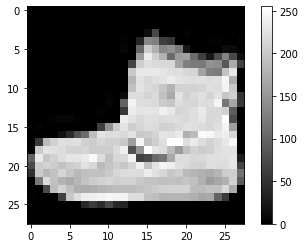

In [23]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [24]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [25]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,0.160784,0.737255,0.403922,0.211765,0.188235,0.168627,0.341176,0.658824,0.521569,0.062745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.192157,0.533333,0.858824,0.847059,0.894118,...,0.956863,0.941176,0.952941,0.839216,0.878431,0.635294,0.000000,0.007843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.0,0.545098,0.572549,0.509804,0.529412,0.529412,0.537255,0.490196,0.486275,0.490196,0.474510,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,0.462745,0.094118,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.345098,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.047059,0.392157,0.831373,0.803922,...,0.415686,0.400000,0.294118,0.039216,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.000000,0.000000,0.070588,0.164706,0.223529,0.219608,0.125490,0.031373,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,0.686275,0.611765,0.250980,0.054902,0.211765,0.537255,0.800000,0.760784,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.286275,0.729412,0.694118,0.717647,0.686275,0.737255,...,0.325490,0.596078,0.333333,0.627451,0.521569,0.392157,0.047059,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015686,0.0,0.007843,0.000000,0.137255,0.015686,0.129412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.741176,0.807843,0.733333,0.125490,...,1.000000,0.949020,1.000000,0.274510,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.239216,0.400000,0.658824,0.098039,0.000000,0.545098,0.631373,0.290196,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [26]:
x_train_tf = tf.convert_to_tensor(train_images.values.reshape((-1, 28, 28, 1)))

### b) Tensor view of the data

In [27]:
x_train_tf.shape

TensorShape([60000, 28, 28, 1])

In [28]:
x_train_tf[0][5]

<tf.Tensor: shape=(28, 1), dtype=float32, numpy=
array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02352941],
       [0.        ],
       [0.4       ],
       [0.8       ],
       [0.6901961 ],
       [0.5254902 ],
       [0.5647059 ],
       [0.48235294],
       [0.09019608],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.04705882],
       [0.03921569],
       [0.        ]], dtype=float32)>

## 3. Model definition

### a.1) Generator

In [29]:
# for weight initialization
initializer_nn = tf.random_uniform_initializer(minval=-1, maxval=1)
def generator_model():   
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2DTranspose(64, (7,7), input_shape=(1, 1, 100), strides=1, padding='valid', use_bias=True, name="Conv2D1"))
    model.add(keras.layers.BatchNormalization(name="Batchnorm1"))
    model.add(keras.layers.ReLU(name="LeakyRelu1"))
    assert model.output_shape == (None, 7, 7, 64)

    model.add(keras.layers.Conv2DTranspose(32, (8, 8), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D2"))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(keras.layers.BatchNormalization(name="Batchnorm2"))
    model.add(keras.layers.ReLU(name="LeakyRelu2"))

    model.add(keras.layers.Conv2DTranspose(1, (15, 15), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid1"))
    assert model.output_shape == (None, 28, 28, 1)

    return model
generator = generator_model()

In [30]:
# generated image not trained
fake_im_not_trained = generator(tf.random.normal([1, 1, 1, 100], 0, 1, tf.float32))
fake_im_not_trained.shape

TensorShape([1, 28, 28, 1])

###  a.2) Inspect the generator model

In [31]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2DTranspose)    (None, 7, 7, 64)          313664    
_________________________________________________________________
Batchnorm1 (BatchNormalizati (None, 7, 7, 64)          256       
_________________________________________________________________
LeakyRelu1 (ReLU)            (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D2 (Conv2DTranspose)    (None, 14, 14, 32)        131104    
_________________________________________________________________
Batchnorm2 (BatchNormalizati (None, 14, 14, 32)        128       
_________________________________________________________________
LeakyRelu2 (ReLU)            (None, 14, 14, 32)        0         
_________________________________________________________________
Conv2D3 (Conv2DTranspose)    (None, 28, 28, 1)        

### a.3) Inspect the first convolutional layer

In [32]:
hidden1_tf_ante = generator.layers[0]
weights_tf_ante, biases_tf_ante = hidden1_tf_ante.get_weights()
weights_tf_ante[0]

array([[[-2.54214853e-02,  1.74338873e-02,  4.59341891e-03, ...,
          1.09285321e-02, -2.49863230e-02, -3.53273749e-03],
        [-6.82957657e-03,  5.45397215e-03,  1.53272804e-02, ...,
         -1.03117470e-02, -2.56510191e-02, -2.34110039e-02],
        [-1.45235844e-02, -4.15397435e-03,  1.13192145e-02, ...,
         -8.53031501e-03,  2.11614389e-02,  1.70462523e-02],
        ...,
        [-2.52806954e-02,  2.60762479e-02,  1.06897820e-02, ...,
          3.16196494e-03, -1.12416577e-02, -2.29777396e-03],
        [ 2.29789820e-02, -1.51758445e-02,  2.66817827e-02, ...,
         -2.67508402e-02,  1.24272238e-02,  7.33315945e-04],
        [-1.65052526e-02,  1.99575070e-02, -2.21969560e-04, ...,
         -2.97153369e-03,  2.26744823e-03, -5.57665154e-03]],

       [[ 8.73211585e-03,  2.52668392e-02,  7.57390819e-03, ...,
         -2.16805059e-02, -2.18791142e-02,  1.43298414e-02],
        [-2.10093129e-02,  3.64277512e-04, -1.90779753e-03, ...,
          2.14828234e-02,  1.44032259e

In [33]:
weights_tf_ante[0].shape

(7, 64, 100)

In [34]:
biases_tf_ante

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [35]:
biases_tf_ante.shape

(64,)

### b.1) Discriminator

In [36]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(input_shape=(28,28,1), filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D1"))
    model.add(keras.layers.AveragePooling2D(pool_size=2, strides=2, name="Pooling1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu1"))
    model.add(keras.layers.Dropout(0.3, name="Dropout1"))
    
    model.add(keras.layers.Conv2D(filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D2"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu2"))
    
    model.add(keras.layers.Conv2D(filters=1, kernel_size=5, strides=1, name="conv2D3"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu3"))
    
    model.add(keras.layers.Flatten(name="Flatten1"))
    
    model.add(keras.layers.Dense(100, kernel_initializer=initializer_nn, name="Dense1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu4"))
    
    model.add(keras.layers.Dense(64, kernel_initializer=initializer_nn, name="Dense2"))
    model.add(keras.layers.Activation(keras.activations.tanh, name="Tanh"))
    
    model.add(keras.layers.Dense(1, kernel_initializer=initializer_nn, name="Dense3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid"))
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [37]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2D)             (None, 28, 28, 2)         52        
_________________________________________________________________
Pooling1 (AveragePooling2D)  (None, 14, 14, 2)         0         
_________________________________________________________________
LeakyRelu1 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 2)         0         
_________________________________________________________________
Conv2D2 (Conv2D)             (None, 14, 14, 2)         102       
_________________________________________________________________
LeakyRelu2 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
conv2D3 (Conv2D)             (None, 10, 10, 1)        

### b.3) Inspect the first convolutional layer

In [38]:
hidden2_tf_ante = discriminator.layers[0]
weights2_tf_ante, biases2_tf_ante = hidden2_tf_ante.get_weights()
weights2_tf_ante[0]

array([[[-0.17601934,  0.17162502]],

       [[-0.10315114,  0.04430395]],

       [[ 0.14566174, -0.25034684]],

       [[-0.00771821, -0.0497575 ]],

       [[-0.14248717,  0.16459459]]], dtype=float32)

In [39]:
biases2_tf_ante

array([0., 0.], dtype=float32)

## 4. Loss & Optimizer

### 4.a) Generator loss

In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits='activation')
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [41]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 4.c) Optimizers

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

## 5. Training

In [43]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_losses = []
    disc_losses = []
    for beg_i in range(0, x_train_tf.shape[0], batch_size):
        x_train_batch_tf = x_train_tf[beg_i:beg_i + batch_size]

        x_fake_batch_tf = tf.random.normal([batch_size, 1, 1, 100], 0, 1, tf.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator( x_fake_batch_tf, training=True)
            real_output = discriminator(x_train_batch_tf, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        
        train_accuracy.update_state(tf.ones_like(real_output), real_output)
        train_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
    return gen_losses, disc_losses

In [44]:
train_losses_generator_tf = []
train_losses_discriminator_tf = []
train_acc_discriminator_tf = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss = train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer)
    train_loss_generator_tf = float(tf.reduce_mean(gen_loss))
    train_loss_discriminator_tf = float(tf.reduce_mean(disc_loss))
    train_losses_generator_tf.append(train_loss_generator_tf)
    train_losses_discriminator_tf.append(train_loss_discriminator_tf)

    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, train_loss_generator_tf, train_loss_discriminator_tf, train_accuracy.result()*100))
    train_acc_discriminator_tf.append(train_accuracy.result()*100)
    train_accuracy.reset_states()
end = time.time()
print(f"Total training time{(end - start)/60.0}")

Epoch 1, Loss_Generator: 1.0989733934402466, Loss_Discriminator: 1.3183459043502808, Discriminator_Accuracy: 68.73416900634766
Epoch 2, Loss_Generator: 2.098090410232544, Loss_Discriminator: 0.5967586040496826, Discriminator_Accuracy: 88.24666595458984
Epoch 3, Loss_Generator: 2.7304930686950684, Loss_Discriminator: 0.5044375658035278, Discriminator_Accuracy: 90.53083038330078
Epoch 4, Loss_Generator: 2.214850664138794, Loss_Discriminator: 0.5441362261772156, Discriminator_Accuracy: 90.09416961669922
Epoch 5, Loss_Generator: 2.723641872406006, Loss_Discriminator: 0.5443629026412964, Discriminator_Accuracy: 89.21749877929688
Epoch 6, Loss_Generator: 2.872645854949951, Loss_Discriminator: 0.527469277381897, Discriminator_Accuracy: 89.61083221435547
Epoch 7, Loss_Generator: 1.7496846914291382, Loss_Discriminator: 0.8225957155227661, Discriminator_Accuracy: 81.48583221435547
Epoch 8, Loss_Generator: 1.1029539108276367, Loss_Discriminator: 1.0869616270065308, Discriminator_Accuracy: 71.5449

### b) Training progress

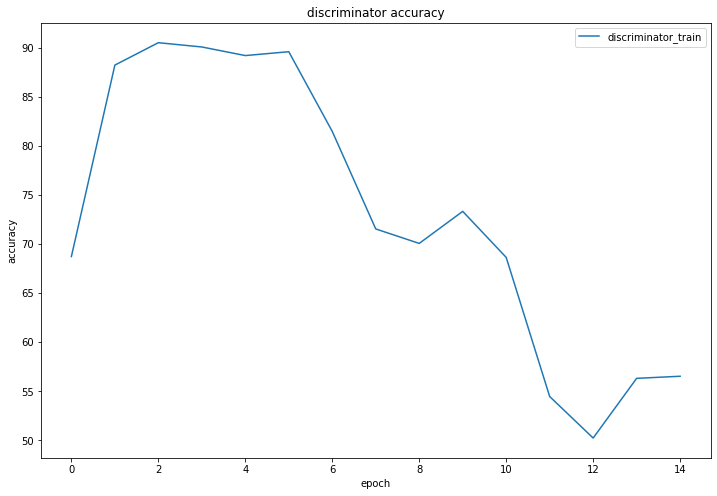

In [45]:
plt.figure(figsize=(12,8))
plt.plot(train_acc_discriminator_tf)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

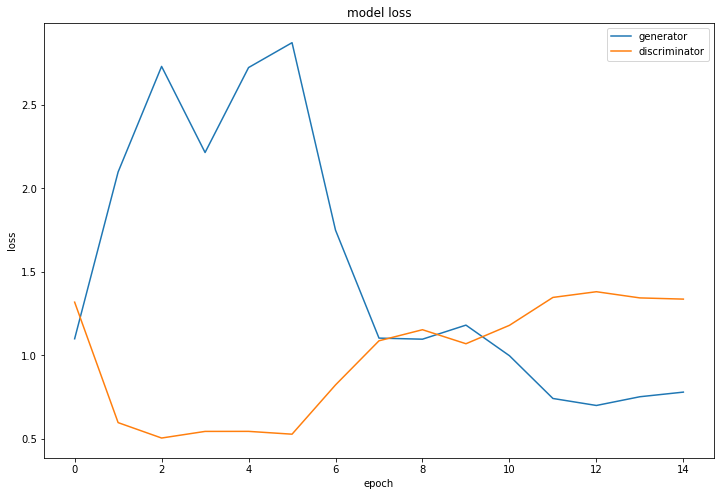

In [46]:
plt.figure(figsize=(12,8))
plt.plot(train_losses_generator_tf)
plt.plot(train_losses_discriminator_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

In [47]:
print(train_losses_generator_tf)
print(train_losses_discriminator_tf)

[1.0989733934402466, 2.098090410232544, 2.7304930686950684, 2.214850664138794, 2.723641872406006, 2.872645854949951, 1.7496846914291382, 1.1029539108276367, 1.096533179283142, 1.1807795763015747, 0.9975360035896301, 0.7414247393608093, 0.6994954347610474, 0.7517799139022827, 0.7794744968414307]
[1.3183459043502808, 0.5967586040496826, 0.5044375658035278, 0.5441362261772156, 0.5443629026412964, 0.527469277381897, 0.8225957155227661, 1.0869616270065308, 1.1532713174819946, 1.0692826509475708, 1.179571270942688, 1.3467285633087158, 1.3808715343475342, 1.3438162803649902, 1.3365873098373413]


### c1) Generator output before training

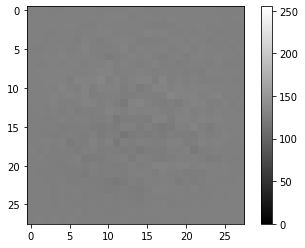

In [48]:
fake_im_not_trained = fake_im_not_trained.numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.clim(0, 255)
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

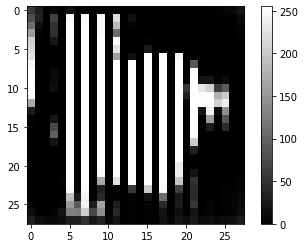

In [49]:
seed2 = tf.random.normal([1, 1, 1, 100], 0, 1, tf.float32)
fake_im = generator(seed2, training=False)
fake_im = fake_im.numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## 6. References
The presented model is based on a combination of two tutorials for deep cnn-gans:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

2) https://www.tensorflow.org/tutorials/generative/dcgan